In [1]:
import numpy as np
import torch
import time
from collections import defaultdict
from typing import Tuple
import random
import matplotlib.pyplot as plt

In [2]:
@torch.jit.script
def euler_hh_scripted(V: torch.Tensor, I: torch.Tensor) -> torch.Tensor:
    """
    编译后的 Hodgkin-Huxley 模型积分函数。
    V: (time_steps, 5, num_neurons, num_protocols)
    I: (time_steps, num_neurons)
    """
    # E_Na = 0.05
    # g_Na = 560.0
    # g_Kd = 60.0
    # E_Kd = -0.09
    # g_Leak = 0.205
    # E_Leak = -0.0703
    # C_membrane = 0.02448
    # vt = -0.0562
    E_Na = 0.05
    g_Na = 500.0
    g_Kd = 100.0
    E_Kd = -0.09
    g_Leak = 1.5
    E_Leak = -0.07
    C_membrane = 0.01
    vt = -0.063
    dt = 0.00005

    # I 的形状：(time_steps, num_neurons) -> (time_steps, 1, num_neurons)
    I_expanded = I.unsqueeze(1)
    T = V.size(0)
    for i in range(T - 1):
        # 取出当前时间步各状态变量，形状：(num_neurons, num_protocols)
        v = V[i, 0, :, :]
        m = V[i, 1, :, :]
        h = V[i, 2, :, :]
        n = V[i, 3, :, :]

        # 计算各通道电流
        I_Leak = g_Leak * (E_Leak - v)
        I_Na = g_Na * (m ** 3) * h * (E_Na - v)
        I_Kd = g_Kd * (n ** 4) * (E_Kd - v)

        # 计算 alpha/beta 参数
        alpham = (-0.32) * (v - vt - 0.013) / (torch.exp(-(v - vt - 0.013) / 0.004) - 1) * 1e6
        betam = 0.28 * (v - vt - 0.040) / (torch.exp((v - vt - 0.040) / 0.005) - 1) * 1e6
        alphah = 0.128 * torch.exp(-(v - vt - 0.017) / 0.018) * 1e3
        betah = 4.0 / (1 + torch.exp(-(v - vt - 0.040) / 0.005)) * 1e3
        alphan = (-0.032) * (v - vt - 0.015) / (torch.exp(-(v - vt - 0.015) / 0.005) - 1) * 1e6
        betan = 0.5 * torch.exp(-(v - vt - 0.010) / 0.040) * 1e3

        # 修改此处：调整注入电流张量的形状与 v 一致
        current_i = I_expanded[i].transpose(0, 1).expand(-1, V.size(3))
        # dv = (1.0 / C_membrane) * (I_Leak + I_Na + I_Kd + I_M + current_i) * dt
        dv = (1.0 / C_membrane) * (I_Leak + I_Na + I_Kd + current_i) * dt
        dm = (1 - torch.exp(-(alpham + betam) * dt)) * (alpham / (alpham + betam) - m)
        dh = (1 - torch.exp(-(alphah + betah) * dt)) * (alphah / (alphah + betah) - h)
        dn = (1 - torch.exp(-(alphan + betan) * dt)) * (alphan / (alphan + betan) - n)
        # dp = (p_inf - p) / tau_hh * dt

        # 更新下一时间步状态
        V[i + 1, 0, :, :] = v + dv
        V[i + 1, 1, :, :] = m + dm
        V[i + 1, 2, :, :] = h + dh
        V[i + 1, 3, :, :] = n + dn
        # V[i + 1, 4, :, :] = p + dp

    V = V * 100.0
    return V


In [3]:
def compute_thresholds(Vt):
    """
    根据膜电位数据计算阈值。
    Vt: [time_steps, protocols, neurons]
    返回：thresholds: [protocols, neurons]
    """
    Vmax = torch.max(Vt, dim=0).values
    Vmin = torch.min(Vt, dim=0).values
    thresholds = Vmax - (Vmax - Vmin) / 3
    thresholds = torch.clamp(thresholds, min=0.5)
    return thresholds
def detect_boundaries(over_threshold):
    """
    检测从低到高（start）和从高到低（end）的阈值过渡点。
    over_threshold: [time_steps, protocols, neurons] 的布尔张量
    返回：starts_idx, ends_idx 分别为起始和终止点的非零索引元组 (time, protocol, neuron)
    """
    starts = (over_threshold[1:] & ~over_threshold[:-1])
    ends = (~over_threshold[1:] & over_threshold[:-1])
    starts_idx = torch.nonzero(starts, as_tuple=True)
    ends_idx = torch.nonzero(ends, as_tuple=True)
    return starts_idx, ends_idx
@torch.jit.script
def detect_peaks_scripted(Vt, thresholds):
    """
    编译后的峰值检测函数。
    参数：
      Vt: (time_steps, protocols, neurons) 的电位数据张量
      thresholds: (protocols, neurons) 的阈值张量
    返回：
      peaks: (time_steps, protocols, neurons) 的布尔张量，标记峰值位置
    """
    potential = Vt[1:-1] > thresholds.unsqueeze(0)
    ascending = Vt[1:-1] > Vt[:-2]
    descending = Vt[1:-1] > Vt[2:]
    potential_peaks = ascending & descending & potential

    peaks_prev = torch.zeros_like(potential_peaks, dtype=torch.bool)
    below_threshold_state = torch.ones(Vt.size(1), Vt.size(2), dtype=torch.bool, device=Vt.device)

    for t in range(potential_peaks.size(0)):
        below_threshold_state = below_threshold_state | (Vt[t + 1] < thresholds)
        peaks_prev[t] = potential_peaks[t] & below_threshold_state
        below_threshold_state = below_threshold_state & (~peaks_prev[t])

    peaks = torch.cat((torch.zeros(1, Vt.size(1), Vt.size(2), dtype=torch.bool, device=Vt.device), peaks_prev), dim=0)
    return peaks
def detect_resets(Vt, thresholds):
    """
    检测重置值（spike resets）
    Vt: [time_steps, protocols, neurons]
    thresholds: [protocols, neurons]
    返回：resets: [time_steps, protocols, neurons] 的布尔张量，表示重置值位置
    """
    below_threshold = Vt[1:-1] < thresholds.unsqueeze(0)
    lower_than_previous = Vt[1:-1] < Vt[:-2]
    lower_than_next = Vt[1:-1] < Vt[2:]
    potential_resets = below_threshold & lower_than_previous & lower_than_next
    resets_prev = torch.zeros_like(potential_resets, dtype=torch.bool)
    above_threshold_state = torch.zeros(Vt.shape[1:], dtype=torch.bool, device=Vt.device)
    for t in range(potential_resets.shape[0]):
        above_threshold_state |= (Vt[t + 1] > thresholds)
        resets_prev[t] = potential_resets[t] & above_threshold_state
        above_threshold_state &= ~resets_prev[t]
    resets = torch.cat((torch.zeros((1, *resets_prev.shape[1:]), dtype=resets_prev.dtype, device=resets_prev.device), resets_prev), dim=0)
    return resets
def map_events(Vt, events_mask):
    """
    将事件（peaks或resets）映射到 Vt 上，获得对应的电位值。
    Vt: [time_steps, protocols, neurons]
    events_mask: [time_steps, protocols, neurons] 的布尔张量
    返回：nonzero_indices, event_values
    """
    mapped_values = Vt[:-1] * events_mask[:]
    indices = torch.nonzero(mapped_values, as_tuple=True)
    return indices, mapped_values[indices]
def build_result_structure(num_protocols, num_neurons):
    result = defaultdict(lambda: defaultdict(lambda: {
        "spike_time": [],
        "spike_amp": [],
        "spike_num": 0,
        "spike_reset": [],
        "width": []
    }))
    for p in range(num_protocols):
        for n in range(num_neurons):
            _ = result[p][n]
    return result
def fill_spike_data(result, times, protocols, neurons, amplitudes):
    # times, protocols, neurons, amplitudes 均为 GPU 张量
    pn_pairs = torch.stack((protocols, neurons), dim=1)  # [N, 2]
    unique_pairs, inverse_indices, counts = torch.unique(pn_pairs, dim=0, return_inverse=True, return_counts=True)
    sorted_inv, sort_idx = torch.sort(inverse_indices, stable=True)
    times_sorted = times[sort_idx]
    amps_sorted = amplitudes[sort_idx]
    cum_counts = torch.cat((torch.tensor([0], device=counts.device, dtype=counts.dtype), counts.cumsum(0)))
    # 一次性将小张量转为 CPU 数组
    unique_pairs_cpu = unique_pairs.cpu().numpy()
    counts_cpu = counts.cpu().numpy()
    cum_counts_cpu = cum_counts.cpu().numpy()
    times_sorted_cpu = times_sorted.cpu().numpy()
    amps_sorted_cpu = amps_sorted.cpu().numpy()
    max_spikes = 30
    for i, (p, n) in enumerate(unique_pairs_cpu):
        start_idx = cum_counts_cpu[i]
        end_idx = cum_counts_cpu[i+1]
        group_size = end_idx - start_idx
        limit = min(group_size, max_spikes)
        if limit > 0:
            selected_times = times_sorted_cpu[start_idx:start_idx+limit].tolist()
            selected_amps = amps_sorted_cpu[start_idx:start_idx+limit].tolist()
            result[int(p)][int(n)]["spike_time"].extend(selected_times)
            result[int(p)][int(n)]["spike_amp"].extend(selected_amps)
            result[int(p)][int(n)]["spike_num"] += int(group_size)
def fill_reset_data(result, protocols_reset, neurons_reset, reset_value):
    pn_pairs = torch.stack((protocols_reset, neurons_reset), dim=1)  # [N, 2]
    unique_pairs, inverse_indices, counts = torch.unique(pn_pairs, dim=0, return_inverse=True, return_counts=True)
    sorted_inv, sort_idx = torch.sort(inverse_indices, stable=True)
    reset_sorted = reset_value[sort_idx]
    cum_counts = torch.cat((torch.tensor([0], device=counts.device, dtype=counts.dtype), counts.cumsum(0)))
    unique_pairs_cpu = unique_pairs.cpu().numpy()
    cum_counts_cpu = cum_counts.cpu().numpy()
    reset_sorted_cpu = reset_sorted.cpu().numpy()
    max_records = 30
    for i, (p, n) in enumerate(unique_pairs_cpu):
        start_idx = cum_counts_cpu[i]
        end_idx = cum_counts_cpu[i+1]
        group_size = end_idx - start_idx
        limit = min(group_size, max_records)
        if limit > 0:
            selected_resets = reset_sorted_cpu[start_idx:start_idx+limit].tolist()
            result[int(p)][int(n)]["spike_reset"].extend(selected_resets)
def fill_width_data(result, starts_idx, ends_idx):
    # starts_idx, ends_idx 均为 GPU 张量，先转换为 CPU 数组一次性获取
    s_t = starts_idx[0].cpu().numpy()
    s_p = starts_idx[1].cpu().numpy()
    s_n = starts_idx[2].cpu().numpy()
    e_t = ends_idx[0].cpu().numpy()
    e_p = ends_idx[1].cpu().numpy()
    e_n = ends_idx[2].cpu().numpy()
    # 构造 numpy 数组
    starts_data = np.stack((s_p, s_n, s_t), axis=1)  # [Ns, 3]
    ends_data = np.stack((e_p, e_n, e_t), axis=1)      # [Ne, 3]
    # 对 starts_data 进行 lex 排序：先按 p，再按 n，最后按 t
    starts_data = starts_data[np.lexsort((starts_data[:,2], starts_data[:,1], starts_data[:,0]))]
    ends_data = ends_data[np.lexsort((ends_data[:,2], ends_data[:,1], ends_data[:,0]))]
    # 分组统计：利用 numpy 的 unique
    unique_s_pn, s_indices, s_counts = np.unique(starts_data[:, :2], axis=0, return_index=True, return_counts=True)
    unique_e_pn, e_indices, e_counts = np.unique(ends_data[:, :2], axis=0, return_index=True, return_counts=True)
    s_cum = np.concatenate(([0], np.cumsum(s_counts)))
    e_cum = np.concatenate(([0], np.cumsum(e_counts)))
    e_map = {}
    unique_e_pn_list = unique_e_pn.tolist()
    for i, pair in enumerate(unique_e_pn_list):
        e_map[tuple(pair)] = (e_cum[i], e_cum[i+1])
    max_starts = 100
    max_ends = 100
    max_width = 30
    for i, pair in enumerate(unique_s_pn.tolist()):
        p, n = pair
        s_start = s_cum[i]
        s_end = s_cum[i+1]
        s_group = starts_data[s_start:s_end]
        s_group = s_group[:max_starts]
        s_times = s_group[:,2]
        if (p, n) not in e_map:
            continue
        e_start, e_end = e_map[(p, n)]
        e_group = ends_data[e_start:e_end]
        e_group = e_group[:max_ends]
        e_times = e_group[:,2]
        idxs = np.searchsorted(e_times, s_times, side='right')
        matched_widths = []
        for st, idx in zip(s_times, idxs):
            if idx < len(e_times):
                width = e_times[idx] - st
                matched_widths.append(width)
                if len(matched_widths) >= max_width:
                    break
        if len(matched_widths) > 0:
            result[int(p)][int(n)]["width"].extend(matched_widths)
def convert_to_regular_dict(result):
    return {
        p: {
            n: {
                "spike_time": data["spike_time"],
                "spike_amp": data["spike_amp"],
                "spike_num": data["spike_num"],
                "spike_reset": data["spike_reset"],
                "width": data["width"]
            }
            for n, data in neuron_data.items()
        }
        for p, neuron_data in result.items()
    }
def spike_detect(V_init, dt=0.00005):
    Vt = V_init[:, :, :]
    thresholds = compute_thresholds(Vt)
    over_threshold = Vt > thresholds.unsqueeze(0)
    starts_idx, ends_idx = detect_boundaries(over_threshold)
    peaks = detect_peaks_scripted(Vt, thresholds)
    resets = detect_resets(Vt, thresholds)
    (peak_times_idx, peak_protocols_idx, peak_neurons_idx), peak_values = map_events(Vt, peaks)
    (reset_times_idx, reset_protocols_idx, reset_neurons_idx), reset_values = map_events(Vt, resets)
    times = peak_times_idx.float() * dt
    _, num_protocols, num_neurons = Vt.shape
    result = build_result_structure(num_protocols, num_neurons)
    fill_spike_data(result, times, peak_protocols_idx, peak_neurons_idx, peak_values)
    fill_reset_data(result, reset_protocols_idx, reset_neurons_idx, reset_values)
    fill_width_data(result, starts_idx, ends_idx)
    result = convert_to_regular_dict(result)
    return result
def spike_num_detect(V_init):
    Vt = V_init[:, :, :]
    thresholds = compute_thresholds(Vt)
    peaks = detect_peaks_scripted(Vt, thresholds)
    (peak_times_idx, peak_protocols_idx, peak_neurons_idx), peak_values = map_events(Vt, peaks)
    _, num_protocols, num_neurons = Vt.shape
    pn_pairs = torch.stack((peak_protocols_idx, peak_neurons_idx), dim=1)
    unique_pairs, inverse_indices, counts = torch.unique(pn_pairs, dim=0, return_inverse=True, return_counts=True)
    spike_counts = torch.zeros((num_protocols, num_neurons), dtype=torch.int64, device='cuda')
    spike_counts[unique_pairs[:, 0], unique_pairs[:, 1]] = counts
    return spike_counts

In [4]:
V_hh1_init = torch.zeros((2000, 5, 10, 1), device='cuda', dtype=torch.float32)
initial_values = torch.tensor([-7.0e-02, 0.3289e-02, 9.993e-1, 1.1314e-02, 0.0], device='cuda')
for i in range(10):
    V_hh1_init[0, :, i, 0] = initial_values
I_hh1 = torch.zeros((2000, 10), device='cuda', dtype=torch.float32)
for i in range(10):
    I_hh1[100:120, i] = 0.086 + i * 0.0172
V_hh1 = euler_hh_scripted(V_hh1_init, I_hh1)
V_hh1_cpu = V_hh1.cpu()

V_hh2_init = torch.zeros((10000, 5, 5, 1), device='cuda', dtype=torch.float32)
for i in range(5):
    V_hh2_init[0, :, i, 0] = initial_values
I_hh2 = torch.zeros((10000, 5), device='cuda', dtype=torch.float32)
I_hh2[:, 0] = 0.01
I_hh2[:, 1] = 0.016
I_hh2[:6000, 2] = 0.018
I_hh2[:4500, 3] = 0.02
I_hh2[:2000, 4] = 0.04
V_hh2 = euler_hh_scripted(V_hh2_init, I_hh2)
V_hh2_cpu = V_hh2.cpu()

# 利用 spike_detect 得到参考数据（两组）
# neuron_data_1 = spike_detect(V_hh1[:, 0, :, :])
# neuron_data_2 = spike_detect(V_hh2[:, 0, :, :])

time_steps = 10000
num_neurons = 1
I_true_zero = torch.zeros((time_steps, 1), device='cuda', dtype=torch.float32)


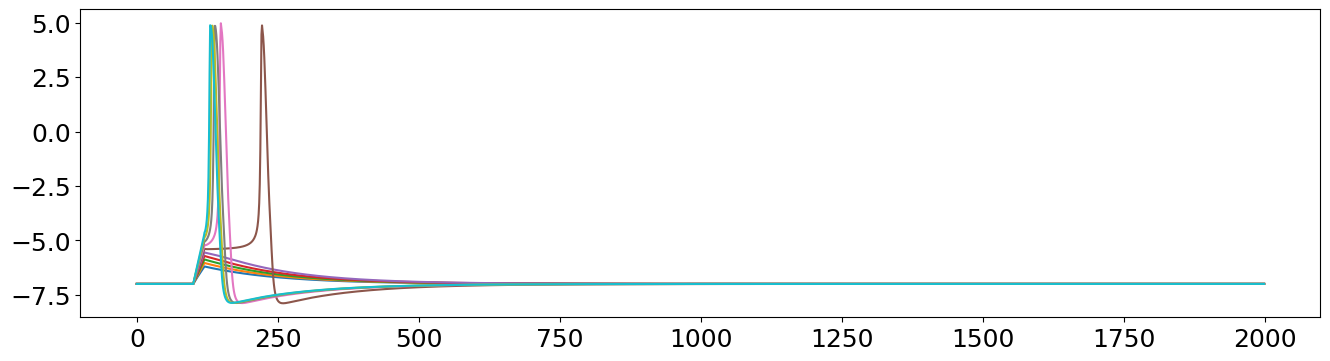

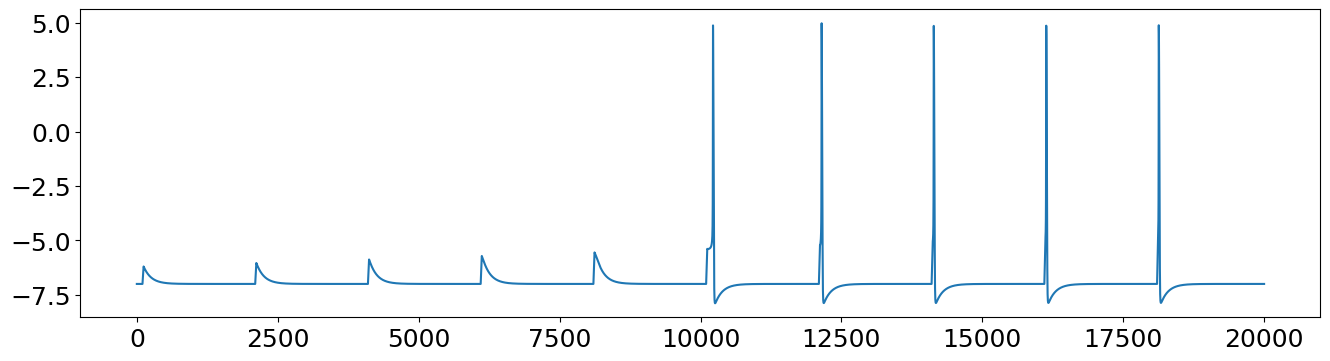

In [5]:
plt.figure(figsize=(16, 4))
plt.rcParams["font.size"] = 18
plt.plot(V_hh1_cpu[:,0,:,0])
#plt.legend()
plt.show()

real_p = []
for i in range(10):
    real_p.extend(V_hh1_cpu[:,0,i,0])
plt.figure(figsize=(16,4))
plt.plot(real_p)
plt.show()



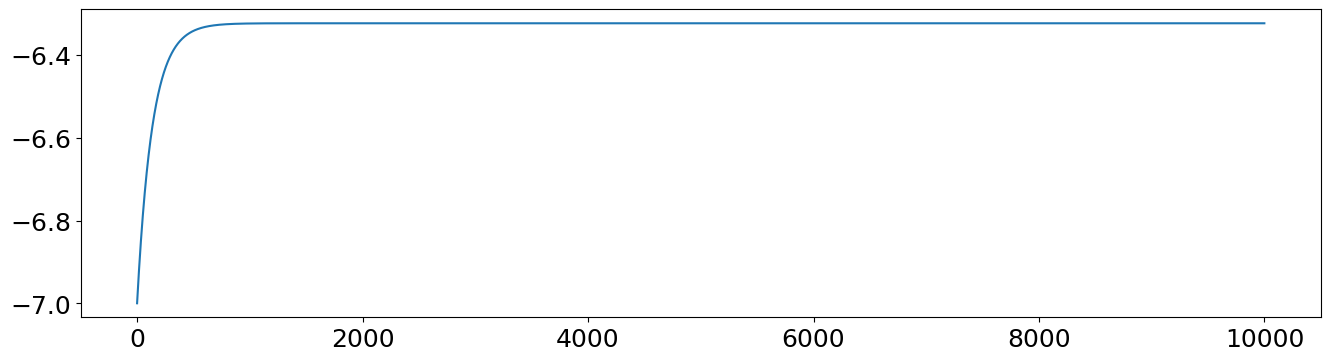

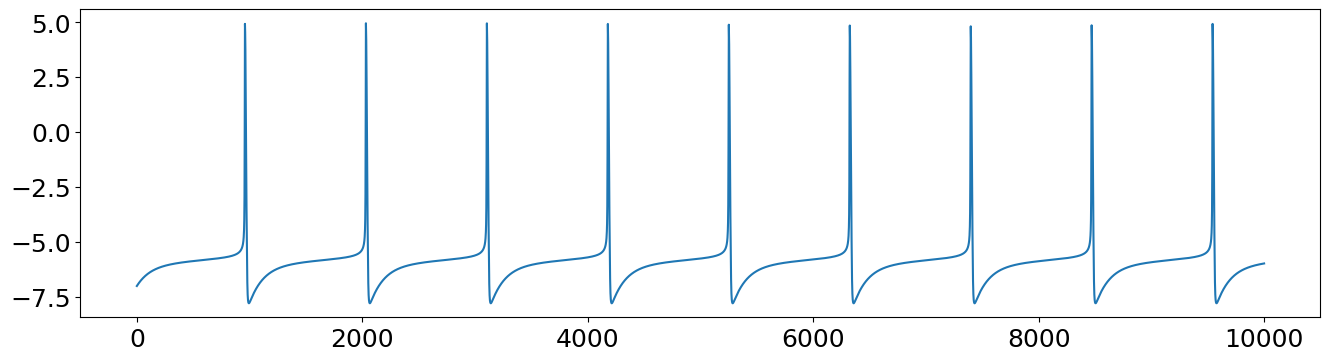

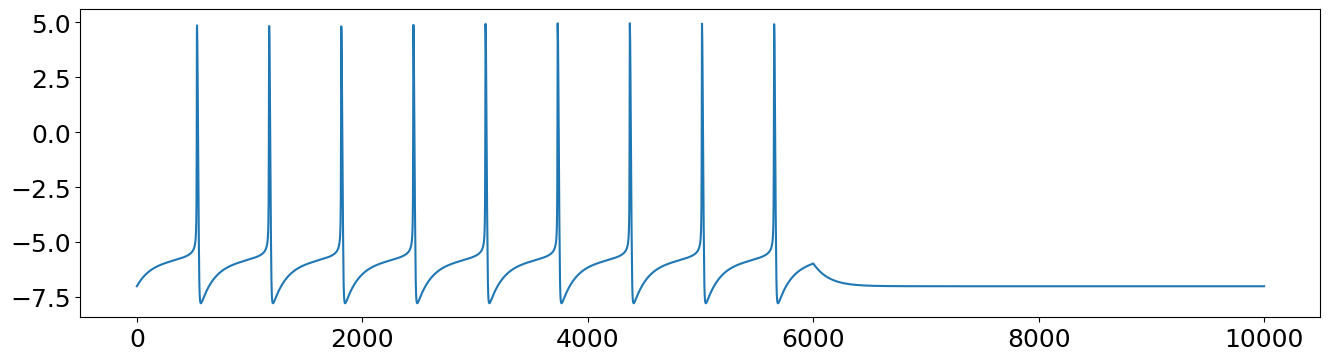

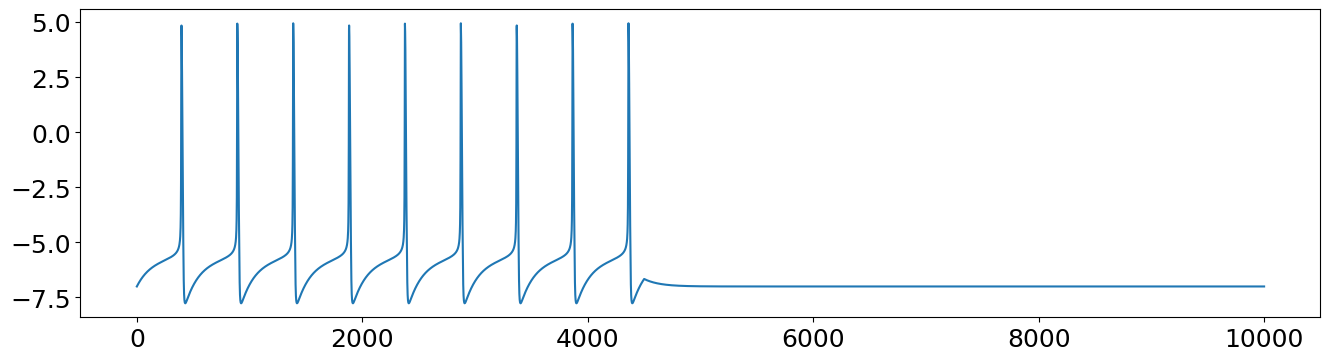

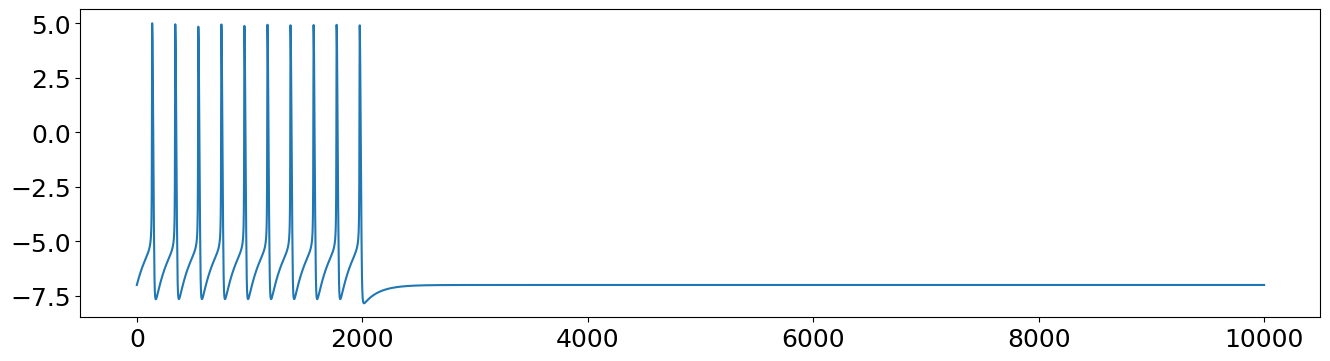

In [6]:
data_list = [
    (V_hh2_cpu[:, 0, 0], "V_hh2[:, 0, 0]"),
    (V_hh2_cpu[:, 0, 1, 0], "V_hh2[:, 0, 1, 0]"),
    (V_hh2_cpu[:, 0, 2, 0], "V_hh2[:, 0, 2, 0]"),
    (V_hh2_cpu[:, 0, 3, 0], "V_hh2[:, 0, 3, 0]"),
    (V_hh2_cpu[:, 0, 4, 0], "V_hh2[:, 0, 4, 0]")
]

# 循环绘制图像
for data, label in data_list:
    plt.figure(figsize=(16, 4))
    plt.plot(data, label=label)
    # plt.legend()  # 如果需要图例，取消注释
    plt.show()

In [23]:
neuron_data_1

{0: {0: {'spike_time': [],
   'spike_amp': [],
   'spike_num': 0,
   'spike_reset': [],
   'width': []}},
 1: {0: {'spike_time': [],
   'spike_amp': [],
   'spike_num': 0,
   'spike_reset': [],
   'width': []}},
 2: {0: {'spike_time': [],
   'spike_amp': [],
   'spike_num': 0,
   'spike_reset': [],
   'width': []}},
 3: {0: {'spike_time': [],
   'spike_amp': [],
   'spike_num': 0,
   'spike_reset': [],
   'width': []}},
 4: {0: {'spike_time': [],
   'spike_amp': [],
   'spike_num': 0,
   'spike_reset': [],
   'width': []}},
 5: {0: {'spike_time': [0.011099999770522118],
   'spike_amp': [4.878310680389404],
   'spike_num': 1,
   'spike_reset': [-7.889039993286133],
   'width': [10]}},
 6: {0: {'spike_time': [0.007449999917298555],
   'spike_amp': [4.977084159851074],
   'spike_num': 1,
   'spike_reset': [-7.880059719085693],
   'width': [11]}},
 7: {0: {'spike_time': [0.006899999920278788],
   'spike_amp': [4.856441020965576],
   'spike_num': 1,
   'spike_reset': [-7.875856876373291],
 

In [24]:
neuron_data_2

{0: {0: {'spike_time': [],
   'spike_amp': [],
   'spike_num': 0,
   'spike_reset': [],
   'width': []}},
 1: {0: {'spike_time': [0.04794999957084656,
    0.10159999877214432,
    0.15524999797344208,
    0.20889998972415924,
    0.2625499963760376,
    0.31619998812675476,
    0.3698499798774719,
    0.4234499931335449,
    0.4770999848842621],
   'spike_amp': [4.9302825927734375,
    4.956626892089844,
    4.953152656555176,
    4.926117897033691,
    4.891073703765869,
    4.853866100311279,
    4.817699909210205,
    4.864701271057129,
    4.928016662597656],
   'spike_num': 9,
   'spike_reset': [-7.786050319671631,
    -7.785863399505615,
    -7.785791873931885,
    -7.786075592041016,
    -7.786284446716309,
    -7.786388874053955,
    -7.786365509033203,
    -7.786255359649658,
    -7.786060333251953],
   'width': [10, 10, 10, 10, 10, 10, 10, 10, 10]}},
 2: {0: {'spike_time': [0.02669999934732914,
    0.05869999900460243,
    0.09064999967813492,
    0.12264999747276306,
    0.1

In [6]:
V_hh1_init = torch.zeros((2000, 5, 10, 1), device='cuda', dtype=torch.float32)
initial_values = torch.tensor([-7.03e-02, 6.538e-04, 9.998e-1, 3.0244e-03, 0.0], device='cuda')
for i in range(10):
    V_hh1_init[0, :, i, 0] = initial_values
I_hh1 = torch.zeros((2000, 10), device='cuda', dtype=torch.float32)
for i in range(10):
    I_hh1[1000:1020, i] = 0.24 + i * 0.048

print(I_hh1[1001])
V_hh1 = euler_hh_scripted(V_hh1_init, I_hh1)
V_hh1_cpu = V_hh1.cpu()

NameError: name 'torch' is not defined

In [1]:
0.24 + 2* 0.048

0.33599999999999997

In [2]:
(0.48 - 0.336) / 0.48

0.29999999999999993

In [2]:
0.1 / 0.48

0.20833333333333334

In [3]:
4.8 * 0.5

2.4

In [4]:
4.8 * 1.5

7.199999999999999

In [5]:
7.2 - 2.4

4.800000000000001

In [7]:
0.384 + 5 * 0.0192

0.48

In [7]:
0.05 / 0.48

0.10416666666666667

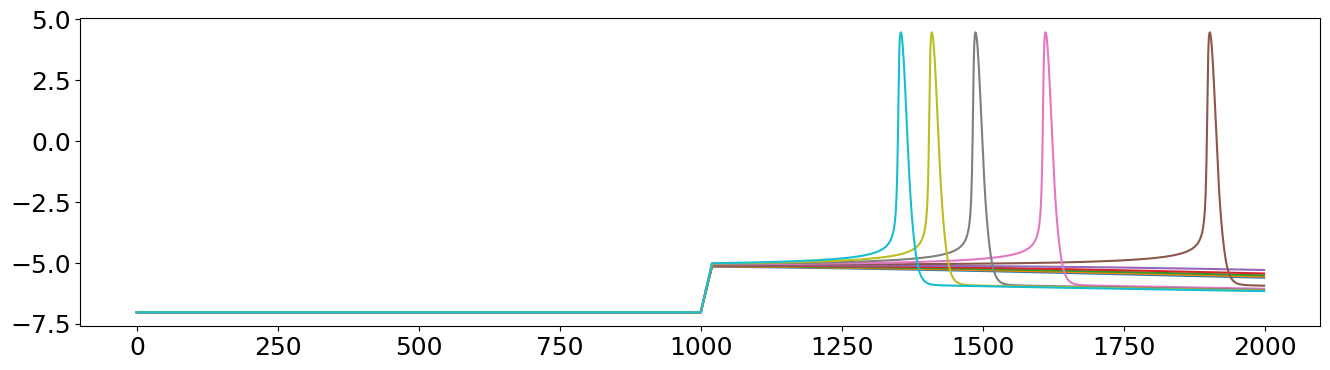

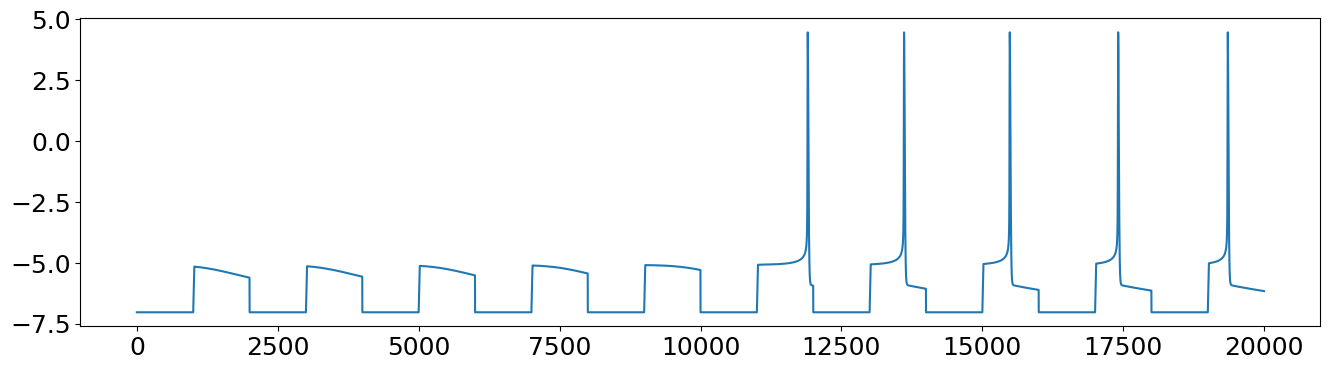

In [22]:
plt.figure(figsize=(16, 4))
plt.rcParams["font.size"] = 18
plt.plot(V_hh1_cpu[:,0,:,0])
#plt.legend()
plt.show()

real_p = []
for i in range(10):
    real_p.extend(V_hh1_cpu[:,0,i,0])
plt.figure(figsize=(16,4))
plt.plot(real_p)
plt.show()


# data_list = [
#     (V_hh2_cpu[:, 0, 0], "V_hh2[:, 0, 0]"),
#     (V_hh2_cpu[:, 0, 1, 0], "V_hh2[:, 0, 1, 0]"),
#     (V_hh2_cpu[:, 0, 2, 0], "V_hh2[:, 0, 2, 0]"),
#     (V_hh2_cpu[:, 0, 3, 0], "V_hh2[:, 0, 3, 0]"),
#     (V_hh2_cpu[:, 0, 4, 0], "V_hh2[:, 0, 4, 0]")
# ]
#
# # 循环绘制图像
# for data, label in data_list:
#     plt.figure(figsize=(4, 1))
#     plt.plot(data, label=label)
#     # plt.legend()  # 如果需要图例，取消注释
#     plt.show()